# 파일 읽기

In [3]:
# Standard library
import warnings
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Statistics & modeling
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    VotingRegressor
)
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    KFold,
    GroupKFold,
    TimeSeriesSplit
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    RobustScaler,
    StandardScaler,
    MinMaxScaler
)
from lightgbm import LGBMRegressor  # pip install lightgbm
from xgboost import XGBRegressor

# Visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

찾은 나눔 폰트:
  C:\Windows\Fonts\NanumBarunpenR.ttf
  C:\Windows\Fonts\NanumSquareR.ttf


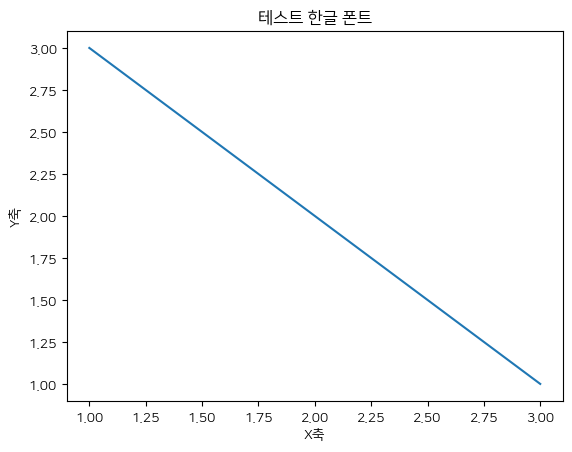

In [4]:
import matplotlib.font_manager as fm

paths = fm.findSystemFonts(fontpaths=None, fontext='ttf')
nanum_fonts = [p for p in paths if 'Nanum' in p]  # 'NanumGothic' 대신 'Nanum' 으로 검색
print("찾은 나눔 폰트:")
for p in nanum_fonts:
    print(" ", p)

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties  # 이 줄 추가!

# 1) 경로 지정 (공백 삭제)
nanum_path = r"C:/Windows/Fonts/NanumSquareR.ttf"

# 2) 폰트 등록
fm.fontManager.addfont(nanum_path)

# 3) 실제 폰트 이름 추출
prop = FontProperties(fname=nanum_path)
font_name = prop.get_name()

# 4) rcParams에 반영
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 5) 테스트 플롯
plt.plot([1,2,3], [3,2,1])
plt.title("테스트 한글 폰트")
plt.xlabel("X축")
plt.ylabel("Y축")
plt.show()

In [5]:
# 파일 읽기
input_path = Path(r"C:/Users/user/OneDrive/Desktop/최강이세용/fatigue_df_delta_ERA.csv")
output_path = input_path.parent / '피로도지수_df.csv'
df_raw = pd.read_csv(input_path)
df_raw.head()

,Name,Year,Team,Date,Role,ERA,WHIP,IP,NP,R,...,직구_구사율,변화구_구사율,이동거리,누적이동거리,속도,avg_FIP,avg_속도,Δ속도,avg_ERA,ΔERA
0,고영표,2021,KT,2021-04-07,SP,1.50,0.83,6.0,88,1,...,28.0,72.0,0,0,134.8,3.155769,137.356522,-2.556522,3.343846,-1.843846
1,고영표,2021,KT,2021-04-13,SP,4.50,1.17,6.0,95,3,...,28.0,72.0,294,570,136.1,3.155769,137.356522,-1.256522,3.343846,1.156154
2,고영표,2021,KT,2021-04-18,SP,3.00,0.83,6.0,91,2,...,28.0,72.0,0,601,137.3,3.155769,137.356522,-0.056522,3.343846,-0.343846
3,고영표,2021,KT,2021-04-24,SP,4.50,1.83,6.0,86,3,...,28.0,72.0,0,1261,136.3,3.155769,137.356522,-1.056522,3.343846,1.156154
4,고영표,2021,KT,2021-04-30,SP,3.86,1.14,7.0,97,3,...,28.0,72.0,39,1339,136.5,3.155769,137.356522,-0.856522,3.343846,0.516154


In [6]:
df_raw = pd.read_csv(input_path)
df_sp = df_raw[df_raw['Role'] == 'SP'].copy()
df_rp = df_raw[df_raw['Role'] == 'RP'].copy()

In [7]:
import numpy as np

# 기본 계산
df_raw['NP_per_IP'] = np.where(df_raw['IP'] == 0, np.nan, df_raw['NP'] / df_raw['IP'])

# 날짜 정렬을 위해 datetime 변환
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# Name-Year별로 정렬
df_raw = df_raw.sort_values(by=['Name', 'Year', 'Date'])

In [8]:
df_raw['NP_per_IP']

0        14.666667
1        15.833333
2        15.166667
3        14.333333
4        13.857143
           ...    
17523    14.428571
17524    22.071429
17525    13.227273
17526    12.857143
17527    14.666667
Name: NP_per_IP, Length: 17528, dtype: float64

In [9]:
from sklearn.preprocessing import StandardScaler

def add_fatigue_features(df_input):
    """
    시계열 기반 피로도 지표를 추가하는 함수.
    입력: df_input (DataFrame) - 'Name', 'Date' 포함되어 있어야 함
    출력: 피로도 관련 컬럼이 추가된 DataFrame
    """

    df = df_input.copy()

    # 날짜 정렬
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by=['Name', 'Date'])

    # 혹사지수 계산 (전 경기 기반)
    df['혹사지수'] = (
        df['연투 여부'].astype(int) * 5 +
        df['연투일'] * 2 -
        df['휴식일 수']
    )

    # 시계열 기반 rolling 피처 생성 (최근 3경기 기준)
    df['NP_roll3'] = df.groupby('Name')['NP'].rolling(window=3, min_periods=1).sum().reset_index(level=0, drop=True)
    df['IP_roll3'] = df.groupby('Name')['IP'].rolling(window=3, min_periods=1).sum().reset_index(level=0, drop=True)
    df['직구_구사율_roll3'] = df.groupby('Name')['직구_구사율'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)

    # 전 등판의 혹사지수 (shift)
    df['혹사지수_prev'] = df.groupby('Name')['혹사지수'].shift(1)

    # 필요 시 정규화된 지표 생성도 가능
    fatigue_cols = ['NP_roll3', 'IP_roll3', '직구_구사율_roll3', '혹사지수_prev']
    df_scaled = df.copy()
    valid = df[fatigue_cols].dropna()
    scaler = StandardScaler()
    scaled = scaler.fit_transform(valid)
    df_scaled.loc[valid.index, [f + '_norm' for f in fatigue_cols]] = scaled

    return df_scaled


In [10]:
df_raw = add_fatigue_features(df_raw)

In [11]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, zscore

def shap_linear_fatigue_score(
    df,
    target='GSv2',
    remove_outliers=False,
    model_name='LogSHAP_LR'
):
    """
    로그 + SHAP + 선형 회귀 기반 fatigue score 생성 함수 (피처 자동 지정)

    Args:
        df (pd.DataFrame): 원본 데이터프레임
        target (str): 예측할 변수
        remove_outliers (bool): 이상치 제거 여부
        model_name (str): 출력용 모델 이름

    Returns:
        model, r2, fatigue_score
    """

    # ✅ 자동 피처 설정
    log_features = []
    norm_features = ['NP_per_IP', '직구_구사율_roll3_norm', '혹사지수_prev_norm']

    # 로그 변환 피처 적용
    log_feats_transformed = []
    for feat in log_features:
        if (df[feat] > 0).all():
            df[f'log_{feat}'] = np.log1p(df[feat])
            log_feats_transformed.append(f'log_{feat}')
        else:
            print(f"⚠️ {feat}: 0 이하 값 존재 → log1p 생략")

    fatigue_feats = log_feats_transformed + norm_features
    df_model = df[fatigue_feats + [target]].dropna().copy()

    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_model[fatigue_feats])
    X_scaled = pd.DataFrame(X_scaled, columns=fatigue_feats, index=df_model.index)
    y = df_model[target].values

    # 선형 회귀
    model = LinearRegression()
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)
    r2 = r2_score(y, y_pred)

    # SHAP 계산
    explainer = shap.Explainer(model, X_scaled)
    shap_values = explainer(X_scaled).values

    # SHAP 가중치
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    weights = mean_abs_shap / mean_abs_shap.sum()
    weight_dict = dict(zip(fatigue_feats, weights))

    print("\n📊 SHAP 기반 가중치:")
    for k, v in weight_dict.items():
        print(f"{k}: {v:.3f}")

    # 피로도 점수
    fatigue_score = X_scaled.mul(weights, axis=1).sum(axis=1)
    df_model['weighted_fatigue_score'] = fatigue_score

    # 이상치 제거
    if remove_outliers:
        residuals = y - y_pred
        z_resid = zscore(residuals)
        outlier_idx = df_model[np.abs(z_resid) > 3].index
        print(f"\n⚠️ 이상치 {len(outlier_idx)}개 제거됨.")
        df_model = df_model.drop(index=outlier_idx)
        fatigue_score = df_model['weighted_fatigue_score']
        y = df_model[target].loc[fatigue_score.index].values
        X_scaled = X_scaled.loc[fatigue_score.index]

    # 피어슨 상관 + 시각화
    corr, pval = pearsonr(fatigue_score, y)
    print(f"\n📌 Fatigue Score vs {target} → 피어슨 r = {corr:.3f}, p = {pval:.3f}")

    sns.regplot(x=fatigue_score, y=y, line_kws={"color": "red"})
    plt.title(f"[{model_name}] Fatigue Score vs {target}")
    plt.xlabel("Fatigue Score (log + SHAP weighted)")
    plt.ylabel(target)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, r2_score(y, model.predict(X_scaled)), fatigue_score



📊 SHAP 기반 가중치:
NP_per_IP: 0.504
직구_구사율_roll3_norm: 0.246
혹사지수_prev_norm: 0.250

⚠️ 이상치 382개 제거됨.

📌 Fatigue Score vs GSv2 → 피어슨 r = -0.441, p = 0.000


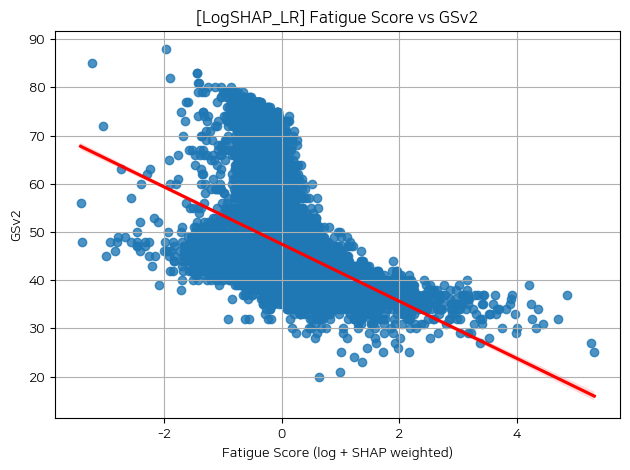

In [12]:
model, r2, fatigue_score = shap_linear_fatigue_score(df_raw, target='GSv2', remove_outliers=True)

In [13]:
# 1연투 : 1, 2연투 : 1+2, 3연투 : 1+2+3, 4연투 : 1+2+3+4
df_raw['누적연투일'] = df_raw['연투일'] * (df_raw['연투일'] + 1) // 2

In [21]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, zscore

def shap_linear_fatigue_score(
    df,
    target='GSv2',
    remove_outliers=False,
    model_name='LogSHAP_LR'
):
    """
    로그 + SHAP + 선형 회귀 기반 fatigue score 생성 함수 (피처 자동 지정)

    Args:
        df (pd.DataFrame): 원본 데이터프레임
        target (str): 예측할 변수
        remove_outliers (bool): 이상치 제거 여부
        model_name (str): 출력용 모델 이름

    Returns:
        model, r2, fatigue_score
    """

    # ✅ 자동 피처 설정
    log_features = []
    norm_features = ['NP_per_IP', '직구_구사율_roll3_norm', '혹사지수_prev_norm', '누적연투일']

    # 로그 변환 피처 적용
    log_feats_transformed = []
    for feat in log_features:
        if (df[feat] > 0).all():
            df[f'log_{feat}'] = np.log1p(df[feat])
            log_feats_transformed.append(f'log_{feat}')
        else:
            print(f"⚠️ {feat}: 0 이하 값 존재 → log1p 생략")

    fatigue_feats = log_feats_transformed + norm_features
    df_model = df[fatigue_feats + [target]].dropna().copy()

    # 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_model[fatigue_feats])
    X_scaled = pd.DataFrame(X_scaled, columns=fatigue_feats, index=df_model.index)
    y = df_model[target].values

    # 선형 회귀
    model = LinearRegression()
    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)
    r2 = r2_score(y, y_pred)

    # SHAP 계산
    explainer = shap.Explainer(model, X_scaled)
    shap_values = explainer(X_scaled).values

    # SHAP 가중치
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    weights = mean_abs_shap / mean_abs_shap.sum()
    weight_dict = dict(zip(fatigue_feats, weights))

    print("\n📊 SHAP 기반 가중치:")
    for k, v in weight_dict.items():
        print(f"{k}: {v:.3f}")

    # 피로도 점수
    fatigue_score = X_scaled.mul(weights, axis=1).sum(axis=1)
    df_model['weighted_fatigue_score'] = fatigue_score

    # 이상치 제거
    if remove_outliers:
        residuals = y - y_pred
        z_resid = zscore(residuals)
        outlier_idx = df_model[np.abs(z_resid) > 3].index
        print(f"\n⚠️ 이상치 {len(outlier_idx)}개 제거됨.")
        df_model = df_model.drop(index=outlier_idx)
        fatigue_score = df_model['weighted_fatigue_score']
        y = df_model[target].loc[fatigue_score.index].values
        X_scaled = X_scaled.loc[fatigue_score.index]

    # 피어슨 상관 + 시각화
    corr, pval = pearsonr(fatigue_score, y)
    print(f"\n📌 Fatigue Score vs {target} → 피어슨 r = {corr:.3f}, p = {pval:.3f}")

    sns.regplot(x=fatigue_score, y=y, line_kws={"color": "red"})
    plt.title(f"[{model_name}] Fatigue Score vs {target}")
    plt.xlabel("Fatigue Score (log + SHAP weighted)")
    plt.ylabel(target)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, r2_score(y, model.predict(X_scaled)), fatigue_score



📊 SHAP 기반 가중치:
NP_per_IP: 0.414
직구_구사율_roll3_norm: 0.194
혹사지수_prev_norm: 0.197
누적연투일: 0.195

⚠️ 이상치 374개 제거됨.

📌 Fatigue Score vs GSv2 → 피어슨 r = -0.463, p = 0.000


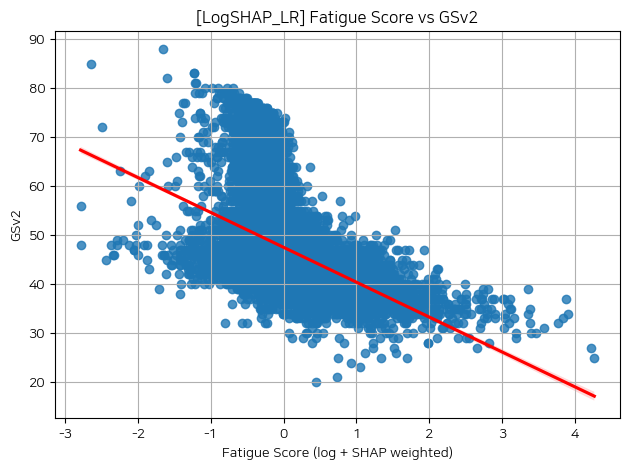

In [22]:
model, r2, fatigue_score = shap_linear_fatigue_score(df_raw, target='GSv2', remove_outliers=True)

In [16]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, zscore

def shap_polynomial_fatigue_score(
    df,
    target='GSv2',
    remove_outliers=False,
    model_name='PolySHAP_LR_deg2'
):
    """
    2차 다항회귀 + SHAP 기반 fatigue score 생성 함수

    Returns:
        model, r2, fatigue_score
    """

    # ✅ 피처 지정
    norm_features = ['NP_per_IP', '직구_구사율_roll3_norm', '혹사지수_prev_norm', '누적연투일']
    df_model = df[norm_features + [target]].dropna().copy()

    # ✅ 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_model[norm_features])
    X_scaled = pd.DataFrame(X_scaled, columns=norm_features, index=df_model.index)
    y = df_model[target].values

    # ✅ 다항 특성 변환 (degree=2)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X_scaled)
    feature_names = poly.get_feature_names_out(norm_features)
    X_poly_df = pd.DataFrame(X_poly, columns=feature_names, index=X_scaled.index)

    # ✅ 선형 회귀 학습
    model = LinearRegression()
    model.fit(X_poly_df, y)
    y_pred = model.predict(X_poly_df)
    r2 = r2_score(y, y_pred)

    # ✅ SHAP 계산
    explainer = shap.Explainer(model, X_poly_df)
    shap_values = explainer(X_poly_df).values

    # ✅ SHAP 기반 피처 가중치 계산
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    weights = mean_abs_shap / mean_abs_shap.sum()
    weight_dict = dict(zip(feature_names, weights))

    print("\n📊 SHAP 기반 가중치 (2차 다항 피처 포함):")
    for k, v in weight_dict.items():
        print(f"{k}: {v:.3f}")

    # ✅ 피로도 점수 계산
    fatigue_score = X_poly_df.mul(weights, axis=1).sum(axis=1)
    df_model['weighted_fatigue_score'] = fatigue_score

    # ✅ 이상치 제거 (선택)
    if remove_outliers:
        residuals = y - y_pred
        z_resid = zscore(residuals)
        outlier_idx = df_model[np.abs(z_resid) > 3].index
        print(f"\n⚠️ 이상치 {len(outlier_idx)}개 제거됨.")
        df_model = df_model.drop(index=outlier_idx)
        fatigue_score = df_model['weighted_fatigue_score']
        y = df_model[target].loc[fatigue_score.index].values
        X_poly_df = X_poly_df.loc[fatigue_score.index]

    # ✅ 시각화
    corr, pval = pearsonr(fatigue_score, y)
    print(f"\n📌 Fatigue Score vs {target} → 피어슨 r = {corr:.3f}, p = {pval:.3f}")
    print(f"📐 다항 회귀 R² = {r2:.3f}")

    sns.regplot(x=fatigue_score, y=y, line_kws={"color": "red"})
    plt.title(f"[{model_name}] Fatigue Score vs {target}")
    plt.xlabel("Fatigue Score (Poly deg=2 + SHAP weighted)")
    plt.ylabel(target)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, r2, fatigue_score



📊 SHAP 기반 가중치 (2차 다항 피처 포함):
NP_per_IP: 0.229
직구_구사율_roll3_norm: 0.115
혹사지수_prev_norm: 0.171
누적연투일: 0.188
NP_per_IP^2: 0.011
NP_per_IP 직구_구사율_roll3_norm: 0.023
NP_per_IP 혹사지수_prev_norm: 0.022
NP_per_IP 누적연투일: 0.025
직구_구사율_roll3_norm^2: 0.039
직구_구사율_roll3_norm 혹사지수_prev_norm: 0.032
직구_구사율_roll3_norm 누적연투일: 0.026
혹사지수_prev_norm^2: 0.037
혹사지수_prev_norm 누적연투일: 0.014
누적연투일^2: 0.068

⚠️ 이상치 322개 제거됨.

📌 Fatigue Score vs GSv2 → 피어슨 r = -0.356, p = 0.000
📐 다항 회귀 R² = 0.273


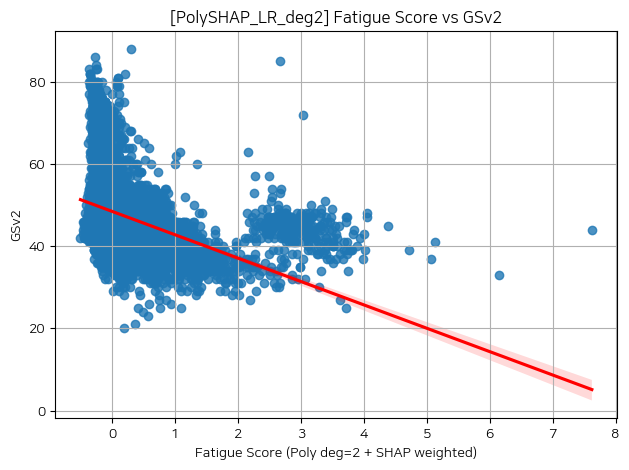

In [17]:
model, r2, fatigue_score = shap_polynomial_fatigue_score(
    df_raw,
    target='GSv2',
    remove_outliers=True,
    model_name='PolySHAP_LR_deg2'
)


In [18]:
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, zscore

def shap_svr_fatigue_score(
    df,
    target='GSv2',
    remove_outliers=False,
    model_name='SVR_RBF_SHAP',
    shap_sample_frac=0.05,
    shap_sample_max=500
):
    """
    RBF 커널 기반 SVR + SHAP으로 피로도 점수 생성 (대표 샘플 기반)

    Returns:
        model, r2, fatigue_score
    """

    # ✅ feature 선택
    norm_features = ['NP_per_IP', '직구_구사율_roll3_norm', '혹사지수_prev_norm', '누적연투일']
    df_model = df[norm_features + [target]].dropna().copy()

    # ✅ 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_model[norm_features])
    X_scaled = pd.DataFrame(X_scaled, columns=norm_features, index=df_model.index)
    y = df_model[target].values

    # ✅ SVR 모델 훈련
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(X_scaled, y)
    y_pred = svr.predict(X_scaled)
    r2 = r2_score(y, y_pred)

    # ✅ SHAP 계산용 샘플 추출
    sample_n = min(int(len(X_scaled) * shap_sample_frac), shap_sample_max)
    X_sample = X_scaled.sample(n=sample_n, random_state=42)

    print(f"\n⚙️ SHAP 계산 샘플 수: {sample_n} / {len(X_scaled)}")

    explainer = shap.KernelExplainer(svr.predict, X_sample.to_numpy())
    shap_values = explainer.shap_values(X_sample.to_numpy(), nsamples=100)

    # ✅ SHAP 가중치 계산
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    weights = mean_abs_shap / mean_abs_shap.sum()
    weight_dict = dict(zip(norm_features, weights))

    print("\n📊 SHAP 기반 가중치 (SVR, 부분 샘플):")
    for k, v in weight_dict.items():
        print(f"{k}: {v:.3f}")

    # ✅ 전체 피로도 점수 계산
    fatigue_score = X_scaled.mul(weights, axis=1).sum(axis=1)
    df_model['weighted_fatigue_score'] = fatigue_score

    # ✅ 이상치 제거 (선택)
    if remove_outliers:
        residuals = y - y_pred
        z_resid = zscore(residuals)
        outlier_idx = df_model[np.abs(z_resid) > 3].index
        print(f"\n⚠️ 이상치 {len(outlier_idx)}개 제거됨.")
        df_model = df_model.drop(index=outlier_idx)
        fatigue_score = df_model['weighted_fatigue_score']
        y = df_model[target].loc[fatigue_score.index].values
        X_scaled = X_scaled.loc[fatigue_score.index]

    # ✅ 시각화
    corr, pval = pearsonr(fatigue_score, y)
    print(f"\n📌 Fatigue Score vs {target} → 피어슨 r = {corr:.3f}, p = {pval:.3f}")
    print(f"📐 SVR (RBF) R² = {r2:.3f}")

    sns.regplot(x=fatigue_score, y=y, line_kws={"color": "red"})
    plt.title(f"[{model_name}] Fatigue Score vs {target}")
    plt.xlabel("Fatigue Score (SVR + SHAP weighted)")
    plt.ylabel(target)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return svr, r2, fatigue_score


In [19]:
# svr_model, r2, fatigue_score = shap_svr_fatigue_score(
#     df_raw,
#     target='GSv2',
#     remove_outliers=True,
#     model_name='SVR_RBF_SHAP'
# )
